In [1]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

RANDOM_SEED = (99565 + 102184 + 97775 + 99635) // 4

# Ejercicio 4

A un cajero automático (ATM) arriban clientes según una distribución exponencial con media que depende del horario según la siguiente tabla:

|Hora desde|Hora hasta|Media (seg)|
|-----|-----|---|
|10:00|12:00|240|
|12:00|15:00|120|
|15:00|19:00|360|

Los clientes se pueden dividir en tres tipos, y en función de ello es el tiempo que utilizan el cajero

|Tipo|Probabilidad|Tiempo de proceso (min)|
|-|--|-------|
|1|.1|4 +/- 3|
|2|.7|2 +/- 1|
|3|.2|3 +/- 2|

Se pide:

1. Determinar la cantidad máxima de personas en fila esperando a usar el atm.
2. Determinar el tiempo máximo de espera en fila.

In [2]:
BETA_CLIENTES_1 = 240/60 # 1/LAMBDA
BETA_CLIENTES_2 = 120/60 # 1/LAMBDA
BETA_CLIENTES_3 = 360/60 # 1/LAMBDA

In [11]:
def obtener_tipo():
    prob = np.random.uniform(0,1)
    if prob < .1 :
        return 1
    elif prob < .8:
        return 2
    return 3

def arribo_de_clientes(env, cajero, tiempos_espera, personas_en_fila):
    cliente_id = 0
    while True:
        tipo = obtener_tipo()
        c = cliente(env, cliente_id, cajero, tipo, tiempos_espera, personas_en_fila)
        env.process(c)
        tiempo = env.now
        if tiempo < 120:
            beta = BETA_CLIENTES_1
        elif tiempo < 120+180:
            beta = BETA_CLIENTES_2
        else:
            beta = BETA_CLIENTES_3
            
        cliente_siguiente = np.random.exponential(beta)                
        yield env.timeout(cliente_siguiente)
        cliente_id += 1

def obtener_tiempo_de_uso(tipo):
    if tipo == 1:
        return np.random.uniform(1,7)
    elif tipo == 2:
        return np.random.uniform(1,3)
    return np.random.uniform(1,5)

def cliente(env, cliente_id, cajero, tipo, tiempos_espera, personas_en_fila):
    arrive = env.now
    personas_en_fila.append(personas_en_fila[-1]+1)
    with cajero.request() as cj:
        yield cj
        personas_en_fila.append(personas_en_fila[-1]-1)
        mi_turno = env.now
        espera = mi_turno - arrive
        tiempos_espera.append(espera)
        t = obtener_tiempo_de_uso(tipo)
        yield env.timeout(t)

def simular_cajero(tiempo_en_minutos=540):
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    tiempos_espera = []
    personas_en_fila = [0]

    env = simpy.Environment()
    cajero = simpy.Resource(env, capacity=1)
    env.process(arribo_de_clientes(env, cajero, tiempos_espera, personas_en_fila))
    env.run(until=tiempo_en_minutos)
    return tiempos_espera, personas_en_fila

In [15]:
tiempos_espera, personas_en_fila = simular_cajero()
print(f'Tiempo de espera maximo: {max(tiempos_espera) :.3f} minutos')
print('Largo maximo de la cola:', max(personas_en_fila), 'personas')

Tiempo de espera maximo: 53.592 minutos
Largo maximo de la cola: 19 personas


# Ejercicio 5

Siguiendo una distribución Exponencial negativa de media 45 ms arriban solicitudes a una granja de servidores, compuesta
por 5 servidores y un balanceador de carga. El tiempo de procesamiento de cada solicitud dependerá del tipo de solicitud
que se trate:

|Tipo|Probabilidad|Tiempo de proceso (mseg)|
|-|--|----------|
|A|.7|120 +/- 60|
|B|.2|240 +/- 120|
|C|.1|500 +/- 300|

Se necesita determinar la mejor política de asignación de procesos a utilizar en el balanceador entre las siguientes:

1. Cada solicitud recibida se asigna al servidor que esté desocupado, y de no haber alguno libre la asignación se hace al que posee menos solicitudes en cola de espera.
2. Utilizando una política Round Robin (la primera solicitud se asigna al servidor 1, la segunda al 2, etc).

Justifique la respuesta midiendo todos los indicadores que considere necesarios

In [5]:
BETA = 45

In [6]:
def obtener_tipo_solicitud():
    prob = np.random.uniform(0,1)
    if prob < .7 :
        return 1
    elif prob < .9:
        return 2
    return 3

def obtener_tiempo_de_procesamiento(tipo):
    if tipo == 1:
        return np.random.uniform(60, 180)
    elif tipo == 2:
        return np.random.uniform(120, 360)
    return np.random.uniform(200, 800)

def obtener_servidor_round_robin(granja, solicitud_id):
    id_servidor =  solicitud_id % len(granja)
    return id_servidor

def obtener_servidor_menos_cargado(granja, solicitud_id):
    servidor = 0
    for i in range(len(granja)):
        if len(granja[i].queue) <= len(granja[servidor].queue):
            servidor = i
    return servidor

def procesar_solicitud(env, id_solicitud, id_servidor, granja, tiempos_espera, solicitudes_por_servidor):
    tipo = obtener_tipo_solicitud()
    arrive = env.now
    servidor = granja[id_servidor]
    cola = solicitudes_por_servidor[id_servidor]
    cola.append(cola[-1] + 1)
    with servidor.request() as srv:
        yield srv
        cola.append(cola[-1] - 1)
        mi_turno = env.now
        espera = mi_turno - arrive
        tiempos_espera.append(espera)
        t = obtener_tiempo_de_procesamiento(tipo)
        yield env.timeout(t)

def arribo_de_solicitudes(env, obtener_servidor, granja, tiempos_espera, solicitudes_por_servidor, dont_hate_me):
    id_solicitud = 0
    while True:
        id_servidor = obtener_servidor(granja, id_solicitud)
        solicitud = procesar_solicitud(env, id_solicitud, id_servidor, granja, tiempos_espera, solicitudes_por_servidor)
        env.process(solicitud)
        yield env.timeout(np.random.exponential(BETA))
        
        id_solicitud += 1
        dont_hate_me[0] = id_solicitud

def simular_servidor(obtener_servidor, n_servidores=5, tiempo_en_ms=1e6):
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    
    env = simpy.Environment()
    
    granja = [simpy.Resource(env, capacity=1) for _ in range(n_servidores)]
    tiempos_espera = []
    solicitudes_por_servidor = [[0] for _ in range(n_servidores)]
    id_solicitud = [0]
    
    env.process(arribo_de_solicitudes(env, obtener_servidor, granja, tiempos_espera, solicitudes_por_servidor, id_solicitud))
    env.run(until=tiempo_en_ms)

    print('tiempo de espera maximo: ',max(tiempos_espera))
    for n, cola_historica_servidor in enumerate(solicitudes_por_servidor):
        print(f'servidor {n}, largo maximo de la cola {max(cola_historica_servidor)}')
    
    return tiempos_espera, solicitudes_por_servidor, id_solicitud[0]
        
def plotear_solicitudes(solicitudes_por_servidor):
    plt.figure(figsize=(15,6))
    medias = []
    maximos = []
    n_solicitudes = min(len(solicitudes) for solicitudes in solicitudes_por_servidor)
    for i in range(n_solicitudes):
        medias.append(sum([solicitudes[i] for solicitudes in solicitudes_por_servidor]) / len(solicitudes_por_servidor))
        maximos.append(max([solicitudes[i] for solicitudes in solicitudes_por_servidor]))
        
    plt.plot(medias, alpha=0.5)
    plt.plot(maximos, alpha=0.5)

In [7]:
tiempos_espera_mc, solicitudes_por_servidor_mc, cant_solicitudes_mc = simular_servidor(obtener_servidor_menos_cargado)
tiempos_espera_rr, solicitudes_por_servidor_rr, cant_solicitudes_rr = simular_servidor(obtener_servidor_round_robin)

tiempo de espera maximo:  1750.1983028865652
servidor 0, largo maximo de la cola 6
servidor 1, largo maximo de la cola 6
servidor 2, largo maximo de la cola 6
servidor 3, largo maximo de la cola 7
servidor 4, largo maximo de la cola 7
tiempo de espera maximo:  3080.0764390706245
servidor 0, largo maximo de la cola 12
servidor 1, largo maximo de la cola 14
servidor 2, largo maximo de la cola 10
servidor 3, largo maximo de la cola 13
servidor 4, largo maximo de la cola 10


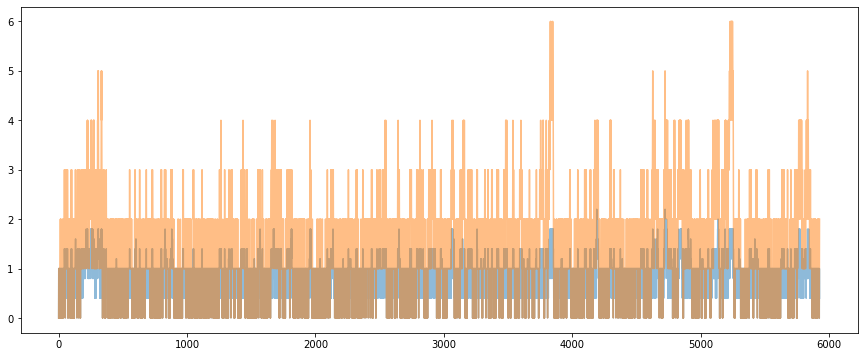

In [8]:
plotear_solicitudes(solicitudes_por_servidor_mc)

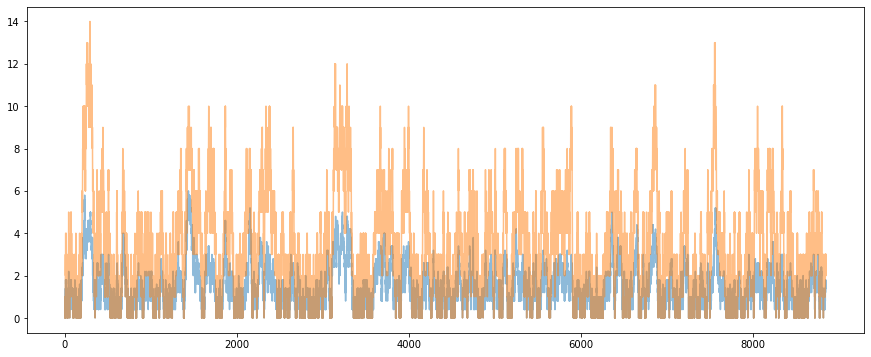

In [9]:
plotear_solicitudes(solicitudes_por_servidor_rr)

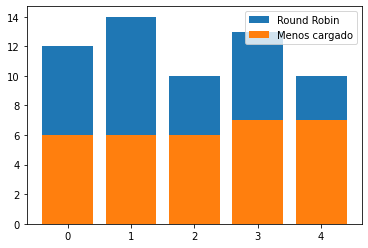

In [10]:
plt.bar([i for i in range(len(solicitudes_por_servidor_rr))], [max(solicitudes) for solicitudes in solicitudes_por_servidor_rr], label='Round Robin');
plt.bar([i for i in range(len(solicitudes_por_servidor_mc))], [max(solicitudes) for solicitudes in solicitudes_por_servidor_mc], label='Menos cargado');
plt.legend();